In [152]:
%matplotlib inline

from matplotlib import animation, rc
from matplotlib import pyplot as plt
import numpy as np

#Import our simulator
from SWESimulators import FBL, CTCS, LxF, KP07, DataOutput, PlotHelper

rc('figure', figsize=(16.0, 12.0))
rc('animation', html='html5')

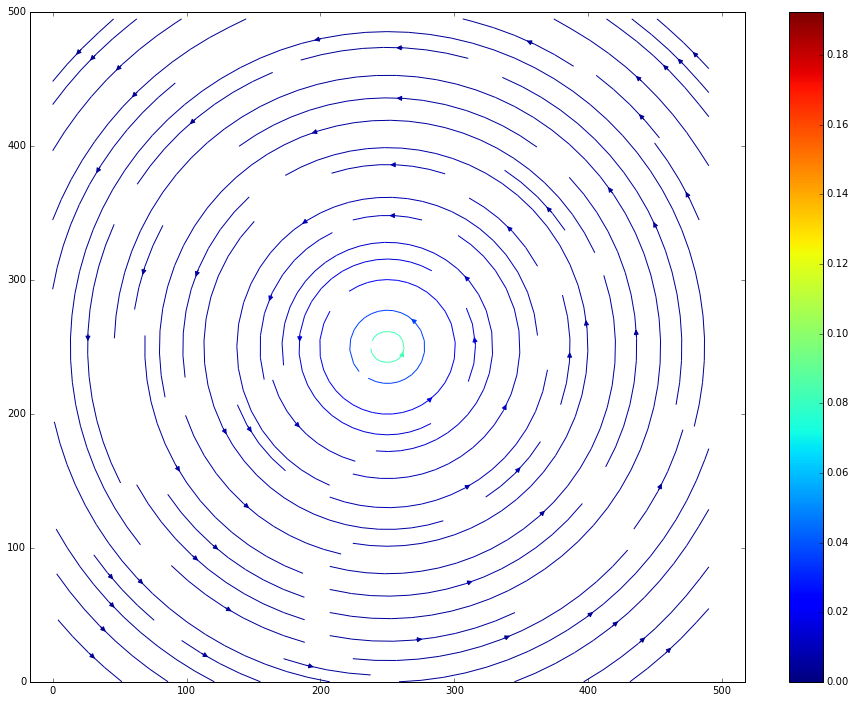

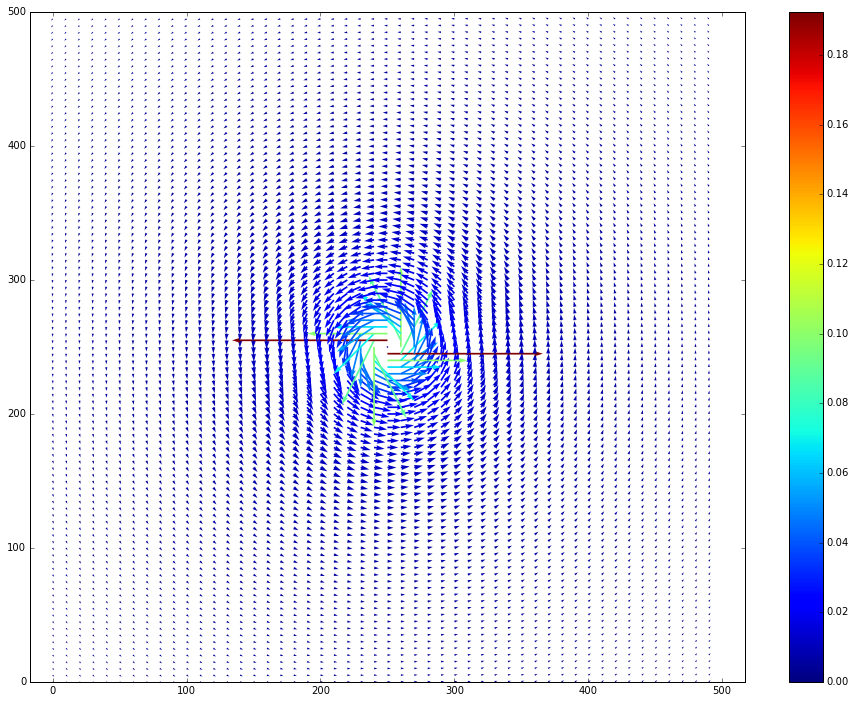

In [153]:
nx = 50
ny = 100

dx = 10
dy = 5

#Generate coordinates for each point
x_coords = np.linspace(0, (nx-1)*dx, nx)
y_coords = np.linspace(0, (ny-1)*dy, ny)

#Generate the mesh of points
x, y = np.meshgrid(x_coords, y_coords)

#Generate our vector field
x0 = (nx/2.0)*dx
y0 = (ny/2.0)*dy
x_vec = x - x0
y_vec = y - y0
r = np.sqrt(x_vec*x_vec + y_vec*y_vec)
vx, vy = (-y_vec, x_vec) / (r*r+1.0)
v = np.sqrt(vx*vx + vy*vy)

#Plot our vector field
plt.figure()
plt.streamplot(x_coords, y_coords, vx, vy, color=v)
plt.colorbar()
plt.axis('equal')

plt.figure()
plt.quiver(x, y, vx, vy, v)
plt.axis('equal')
plt.colorbar()

0.0 0.0
0.0 0.0
0.0999800039992 0.800039992002
0.0999800039992 0.800039992002
0.101006049533 0.802214976193
0.101006049533 0.802214976193
0.203061674828 0.606568585054
0.203061674828 0.606568585054
0.204060009218 0.608770372657
0.204060009218 0.608770372657
0.308135345844 0.417490428675
0.308135345844 0.417490428675
0.309105596068 0.419718102886
0.309105596068 0.419718102886
0.415144043562 0.232855540168
0.415144043562 0.232855540168
0.416085979724 0.235108016325
0.416085979724 0.235108016325
0.524030535018 0.052711542705
0.524030535018 0.052711542705
0.524944070431 0.0549875757882
0.524944070431 0.0549875757882
0.634737615375 0.877103358246
0.634737615375 0.877103358246
0.635586721334 0.879240178566
0.635586721334 0.879240178566
0.747100393243 0.705597386125
0.747100393243 0.705597386125
0.74790921786 0.70767347326
0.74790921786 0.70767347326
0.861061744761 0.538151226491
0.861061744761 0.538151226491
0.861846827165 0.540235749053
0.861846827165 0.540235749053
0.976590554855 0.3748503

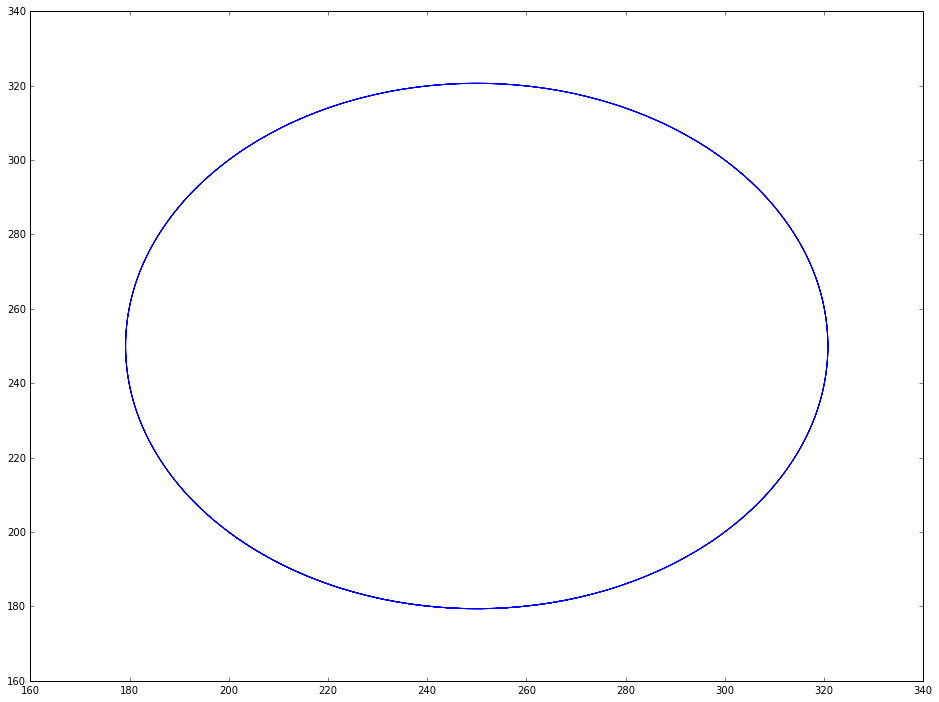

In [154]:
"""
Bilinearly interpolates p(x, y) at the point x0, y0
x and y are 1d arrays with x and y coordintes of 
p, which is a 2d array of values
"""
def bilinear_interpolation(x0, y0, x, y, p):    
    #First, find the cell we are within
    if (x0 <= x[0]): #Extrapolate left
        ip = 1
    elif(x[-1] <= x0): #Extrapolate right
        ip = len(x) - 1
    else: # Interpolate
        ip = np.where(x > x0)[0][0]
    
    if (y0 <=y[0]):
        jp = 0
    elif(y[-1] <= y0):
        jp = len(y) - 1
    else:
        jp = np.where(y > y0)[0][0]    
    
    #Clamp to avoid out of bounds
    ip = min(max(1, ip), len(x) - 1)
    jp = min(max(1, jp), len(y) - 1)
    i = ip-1
    j = jp-1

    #Find how far into the cell we are
    ti = (x0 - x[i]) / (x[ip] - x[i])
    tj = (y0 - y[j]) / (y[jp] - y[j])
    
    print ti, tj

    #Evaluate the bilinear function
    p0 = (1.0-ti)*p[j , i] + ti*p[j , i+1]
    p1 = (1.0-ti)*p[jp, i] + ti*p[jp, i+1]
    p2 = (1.0-tj)*p0 + tj*p1
    
    return p2

"""
Performs ODE integration using the seed point x0, y0 for a time t
x and y are 1d vectors of the x and y coordinates of 
vx and vy, which are 2d arrays with the respective velocities
"""
def rk2_ode(x0, y0, t, dt, x, y, vx, vy):
    nt = int(t / dt)
    
    u = np.zeros(nt)
    v = np.zeros(nt)
    
    u[0] = x0
    v[0] = y0
    
    for k in range(1, nt):
        #First halfstep
        vx1 = bilinear_interpolation(u[k-1], v[k-1], x, y, vx)
        vy1 = bilinear_interpolation(u[k-1], v[k-1], x, y, vy)
        u1 = u[k-1] + dt*vx1
        v1 = v[k-1] + dt*vy1
                
        vx2 = bilinear_interpolation(u1, v1, x, y, vx)
        vy2 = bilinear_interpolation(u1, v1, x, y, vy)
        u2 = u1 + dt*vx2
        v2 = v1 + dt*vy2
        
        u[k] = 0.5*(u[k-1] + u2)
        v[k] = 0.5*(v[k-1] + v2)
        
    return u, v

u, v = rk2_ode(200, 200, 100000, 100, x_coords, y_coords, vx, vy)

plt.plot(u, v)

In [151]:
nx = 25
ny = 50

dx = 20.0*1000
dy = 20.0*1000

dt = 45.0
g = 9.81
f = 0.00012
r = 0.0024
A = 5

wind_type = 0
wind_tau0 = 0.1
wind_rho = 1025.0
wind_alpha = 0.000005

h0 = np.ones((ny+2, nx+2), dtype=np.float32, order='C') * 50.0;
eta0 = np.zeros((ny+2, nx+2), dtype=np.float32, order='C');
hu0 = np.zeros((ny+2, nx+1), dtype=np.float32, order='C');
hv0 = np.zeros((ny+1, nx+2), dtype=np.float32, order='C');

#Create bump in center of domain for testing
x_center = dx*nx/2.0
y_center = dy*ny/2.0
for j in range(-1, ny+1):
    for i in range(-1, nx+1):
        x = dx*i - x_center 
        y = dy*j - y_center
        #if (np.sqrt(x**2 + y**2) < 10*min(dx, dy)):
        #    eta0[j+1, i+1] = 1.0
            
#Initialize simulator
sim = CTCS.CTCS(h0, eta0, hu0, hv0, \
                nx, ny, \
                dx, dy, dt, \
                g, f, r, A,
                wind_type, \
                wind_tau0, wind_rho, wind_alpha)


#Calculate radius from center of bump for plotting
y_coords, x_coords = np.mgrid[0:ny*dy:dy, 0:nx*dx:dx]
x_coords = np.subtract(x_coords, x_center)
y_coords = np.subtract(y_coords, y_center)
radius = np.sqrt(np.multiply(x_coords, x_coords) + np.multiply(y_coords, y_coords))


fig = plt.figure()
plotter = PlotHelper.PlotHelper(fig, x_coords, y_coords, radius, eta0[1:-1, 1:-1], hu0[1:-1, 1:-1], hv0[1:-1, 1:-1])

ss = np.array([40])
tt = np.array([90])

plt.subplot(2, 3, 1)
line, = plt.plot(ss, tt, '-')


def animate(i):
    timestep = 3600.0*24
    t = sim.step(timestep)
    eta1, hu1, hv1 = sim.download()
    
    print t

    vx = hu1*1.0
    vy = hv1*1.0
    x = np.linspace(0, (nx-1), nx)
    y = np.linspace(0, (ny-1), ny)
    global ss, tt
    ss1, tt1 = rk2_ode(ss[-1], tt[-1], 100.0, 10.0, x, y, vx, vy)
    ss = np.concatenate((ss, ss1))
    tt = np.concatenate((tt, tt1))

    plotter.plot(eta1[1:-1, 1:-1], hu1[1:-1, 1:-1], hv1[1:-1, 1:-1]);
    line.set_xdata(ss)
    line.set_ydata(tt)
    plt.suptitle("CTCS Time = " + str(t) + " s", fontsize=18)


anim = animation.FuncAnimation(fig, animate, np.arange(1, 100), interval=100)
plt.close(anim._fig)
anim

Using  GeForce 840M
86400.0
17.0 42.0
17.0 42.0
18.1252951156 36.7120216861
18.1252951156 36.7120216861
18.1442508258 36.9887058203
18.1442508258 36.9887058203
19.3113580077 32.2138531086
19.3113580077 32.2138531086
19.3308577371 32.4739386941
19.3308577371 32.4739386941
20.5408837733 28.1803835775
20.5408837733 28.1803835775
20.5611557992 28.4238529233
20.5611557992 28.4238529233
21.8156651327 24.5798033291
21.8156651327 24.5798033291
21.8369381562 24.8067117542
21.8369381562 24.8067117542
23.137952117 21.3805622658
23.137952117 21.3805622658
23.1604515606 21.5910556548
23.1604515606 21.5910556548
24.5104406589 18.5515677477
24.5104406589 18.5515677477
24.5343858532 18.7458921027
24.5343858532 18.7458921027
25.9362569257 16.0623887237
25.9362569257 16.0623887237
25.961859155 16.2408928122
25.961859155 16.2408928122
27.4189390643 13.8834544435
27.4189390643 13.8834544435
27.4464003972 14.0465867971
27.4464003972 14.0465867971
28.9624178116 11.9862386873
28.9624178116 11.9862386873
1728

C:\Users\anbro\AppData\Local\Enthought\Canopy32\User\lib\site-packages\ipykernel\__main__.py:37: RuntimeWarning: overflow encountered in double_scalars
C:\Users\anbro\AppData\Local\Enthought\Canopy32\User\lib\site-packages\ipykernel\__main__.py:35: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\anbro\AppData\Local\Enthought\Canopy32\User\lib\site-packages\ipykernel\__main__.py:36: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\anbro\AppData\Local\Enthought\Canopy32\User\lib\site-packages\ipykernel\__main__.py:13: RuntimeWarning: invalid value encountered in greater


IndexError: index 0 is out of bounds for axis 0 with size 0

In [119]:
a = np.zeros((100))
a[-1]
a[len(a)-1]

0.0